In [1]:
import typing

import pandas as pd

from gnn_tracking.utils.dictionaries import pivot_record_list
from gnn_tracking.utils.loading import TrackingDataset
from gnn_tracking_hpo.trainable import GCTrainable

%load_ext autoreload
%autoreload 2

In [2]:
trainable = GCTrainable.reinstate(hash="7dce6aff", project="gc-hinge-sq-sq-cells")

[18:46:00 HPO] DEBUG: Loading config from /home/kl5675/ray_results/gc-hinge-sq-sq-cells/GCTrainable_7dce6aff_24_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_decay=_2023-06-08_13-32-02/params.json
[18:46:00 HPO] INFO: I'm running on a node with job ID=48386227
[18:46:00 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[18:46:00 HPO] INFO: The ID of my dispatcher is 0
[18:46:00 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[18:46:00 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1                    │ 0.9                                      │
│ adam_beta2                    │ 0.999                              

In [3]:
val_ds = TrackingDataset(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9",
    stop=1
)

[18:46:01] INFO: DataLoader will load 1 graphs (out of 1000 available).
[18:46:01] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt


In [4]:
data = val_ds[0]

In [5]:
mo = trainable.trainer.evaluate_model(data)

In [6]:
mos = [trainable.trainer.evaluate_model(data) for data in val_ds[:5]]

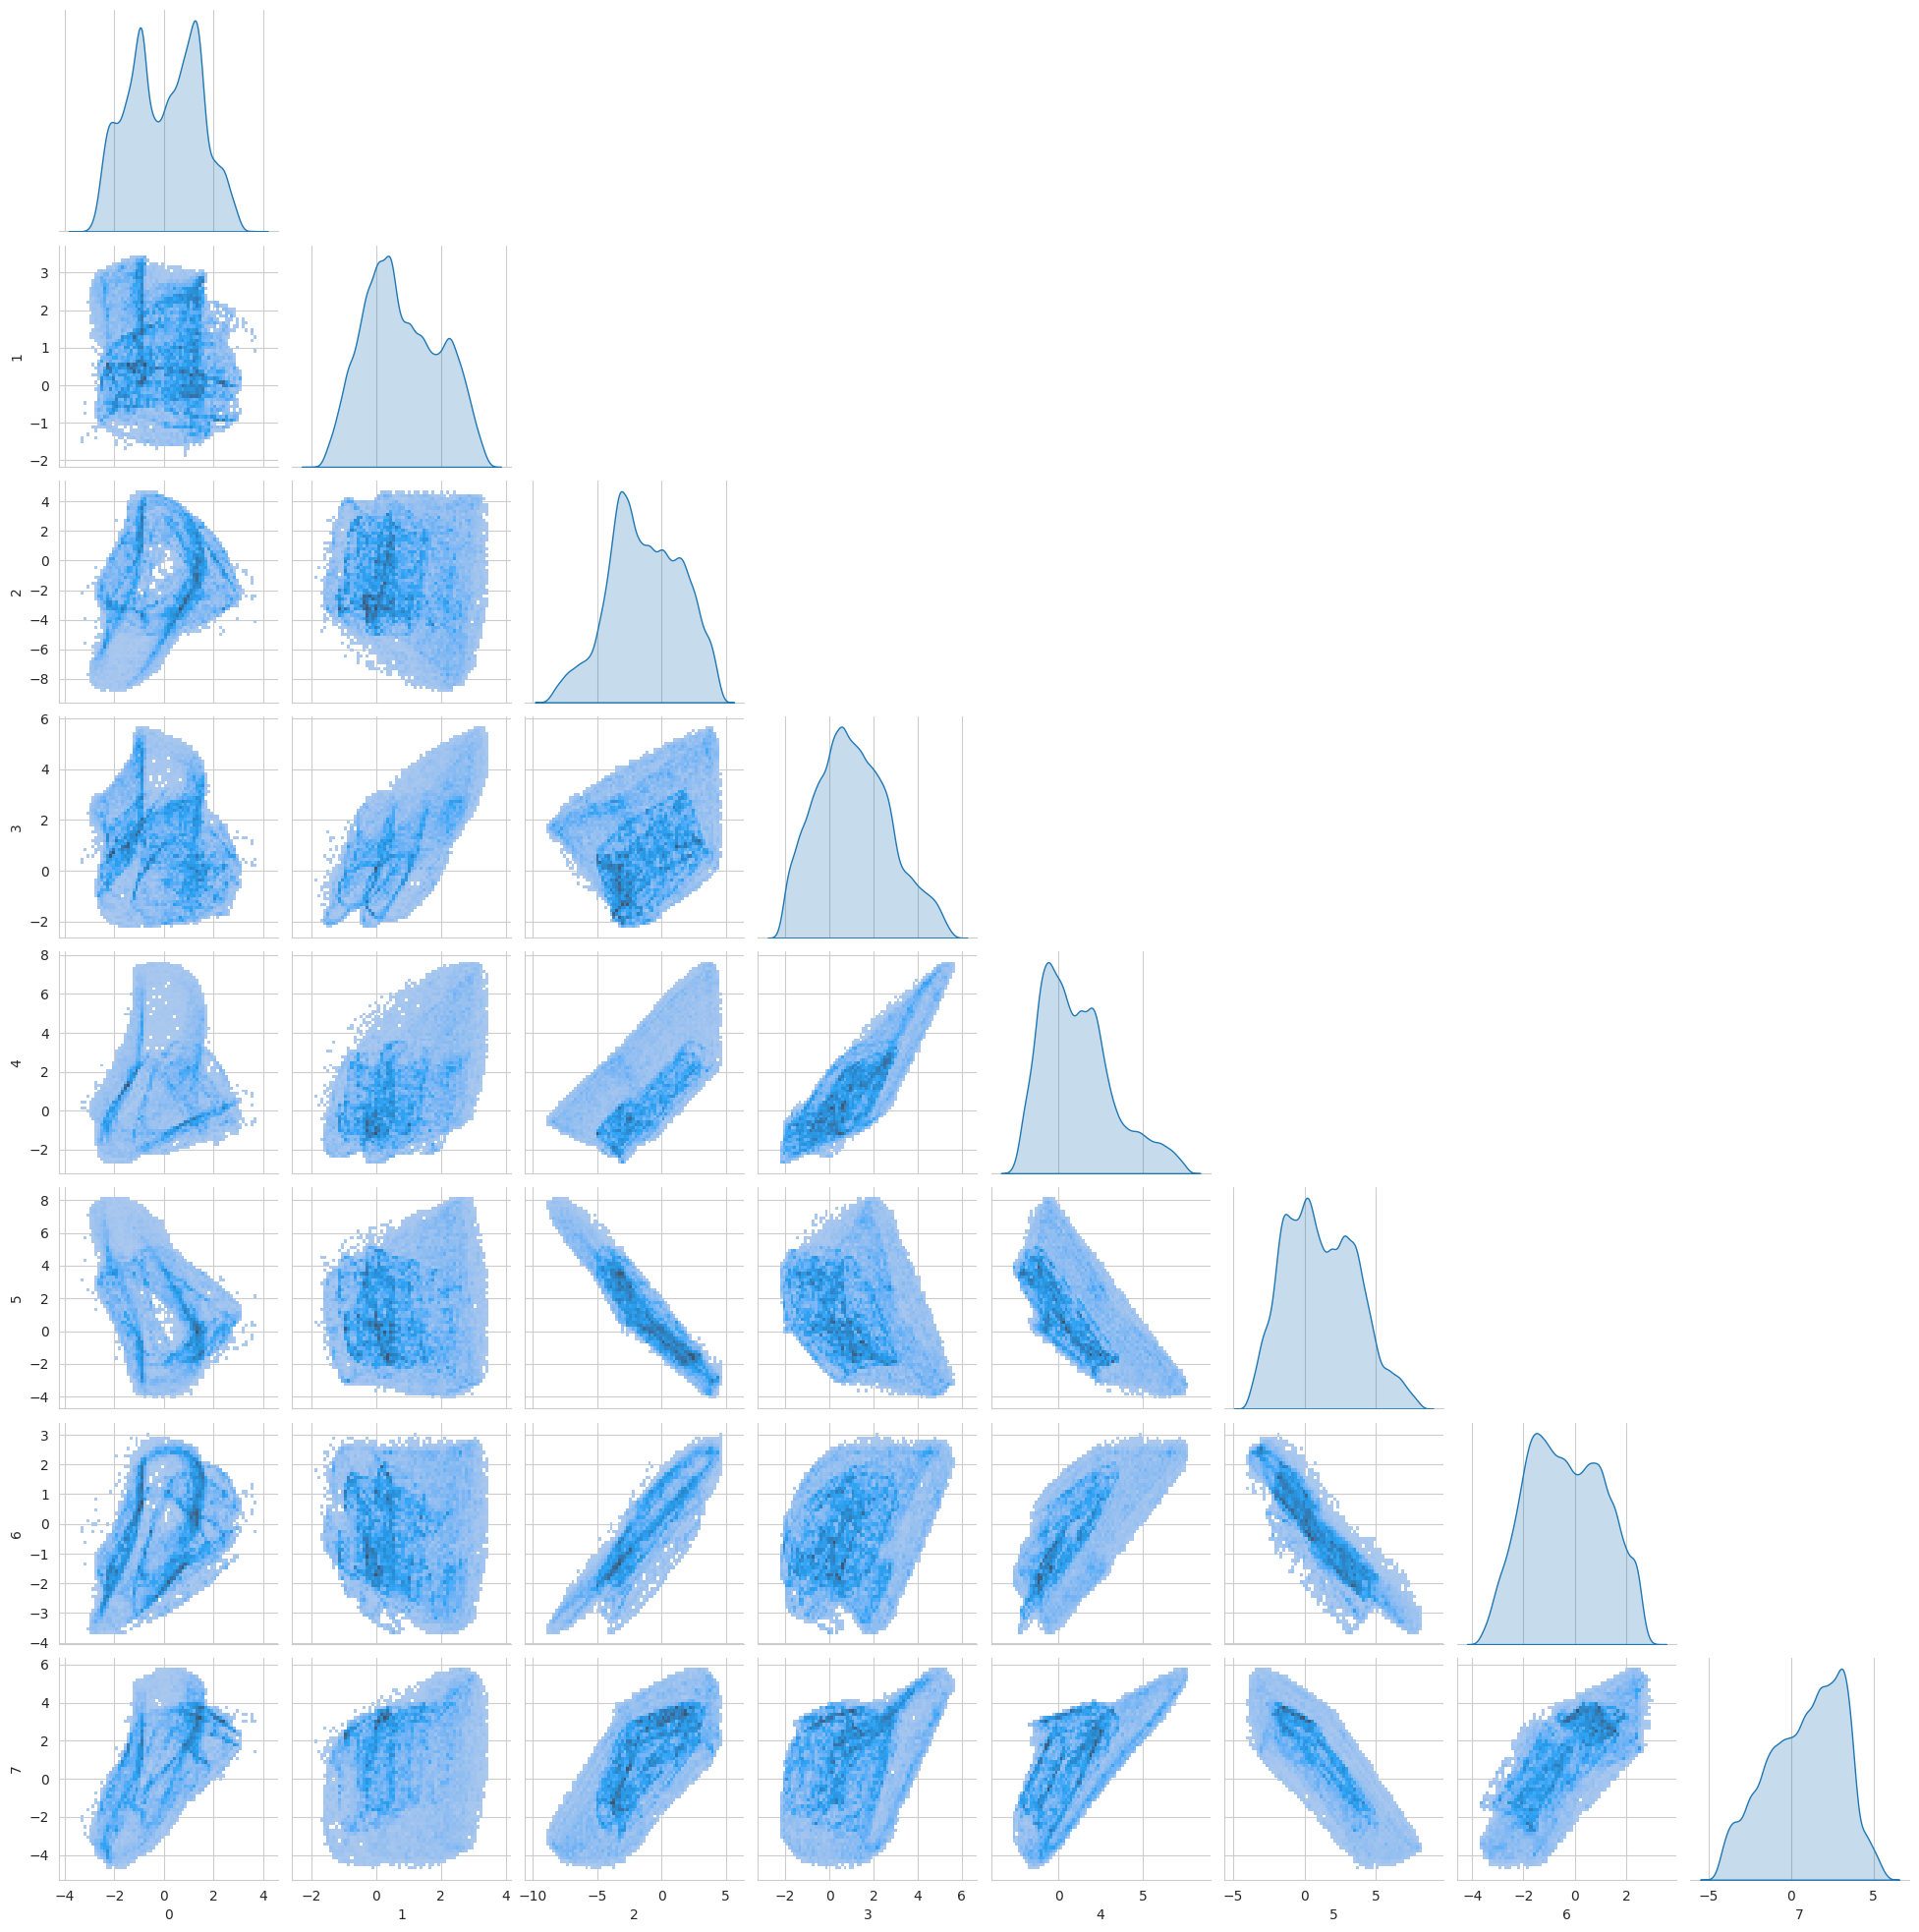

In [6]:
x = mo["x"].detach().cpu().numpy()
import seaborn as sns
sns.pairplot(pd.DataFrame(x), corner=True, diag_kind="kde", kind="hist")

In [7]:
from torch_cluster import knn_graph



In [8]:
from torch_geometric.data import Data
from torch_cluster import knn_graph
from gnn_tracking.analysis.graphs import get_largest_segment_fracs
from gnn_tracking.graph_construction.radius_scanner import RadiusScanner, \
    ComputationAborted


def construct_knn_graph(mo: dict[str, typing.Any], radius) -> Data:
    """Construct radius graph

    Args:
        mo: Model output
        radius: Radius for radius graph
        max_num_neighbors: Maximum number of edges per node (after that: random
            sampling)
    """
    edge_index = knn_with_max_radius(mo["x"], k=radius, max_radius=0.8)
    y: Tensor = (  # type: ignore
        mo["particle_id"][edge_index[0]] == mo["particle_id"][edge_index[1]]
    )
    data = Data(x=mo["x"], edge_index=edge_index, y=y)
    data.pt = mo["particle_id"]
    data.particle_id = mo["particle_id"]
    data.reconstructable = mo["reconstructable"]
    return data


class KNNScanner(RadiusScanner):
    def _objective_single_point_cloud(
        self, mo: dict[str, typing.Any], radius: float
    ) -> dict[str, float | int]:
        """Construct graph for given point cloud and radius

        Returns:
            50%-segment fraction, number of edges. nan is returned for both if
            we exceed maximal number of edges.
        """
        if radius > self._radius_range[1]:
            raise ComputationAborted("Exceeded radius range")
        data = construct_knn_graph(
            mo, radius=int(radius)
        )
        if data.num_edges > self._max_edges:
            self._clip_radius_range(max_radius=radius, reason="too many edges")
            raise ComputationAborted("Too many edges")
        lsfs = get_largest_segment_fracs(data)
        frac50 = (lsfs > 0.5).mean().item()
        frac75 = (lsfs > 0.75).mean().item()
        frac100 = (lsfs == 1).mean().item()
        return {
            "frac50": frac50,
            "frac75": frac75,
            "frac100": frac100,
            "n_edges": data.num_edges,
        }


In [9]:

rs = KNNScanner(
    model_output=mos,
    radius_range=(1, 75),
    max_edges=5_000_000,
    target_fracs=[0.95, 0.97],
    # max_num_neighbors=256,
)

In [10]:
_rsr = rs()

2


[18:46:05 RadiusHP] DEBUG: Radius 38.000000 -> 50-segment: 0.939010, edges: 2167748.000000


2


[18:46:08 RadiusHP] DEBUG: Radius 19.500000 -> 50-segment: 0.890935, edges: 1107973.000000
[18:46:08 RadiusHP] DEBUG: Updated min radius to 19.500000 (underarchieving)


2


[18:46:12 RadiusHP] DEBUG: Radius 56.500000 -> 50-segment: 0.954098, edges: 3053618.000000
[18:46:12 RadiusHP] DEBUG: Updated min radius to 38.000000 (underarchieving)


2


[18:46:15 RadiusHP] DEBUG: Radius 47.250000 -> 50-segment: 0.948856, edges: 2631340.000000
[18:46:15 RadiusHP] DEBUG: Updated min radius to 47.250000 (underarchieving)


2


[18:46:20 RadiusHP] DEBUG: Radius 65.750000 -> 50-segment: 0.957294, edges: 3425490.000000


2


[18:46:23 RadiusHP] DEBUG: Radius 51.875000 -> 50-segment: 0.951796, edges: 2824756.000000


2


[18:46:27 RadiusHP] DEBUG: Radius 61.125000 -> 50-segment: 0.956272, edges: 3266730.000000


2


[18:46:31 RadiusHP] DEBUG: Radius 70.375000 -> 50-segment: 0.958829, edges: 3608800.000000


2


[18:46:35 RadiusHP] DEBUG: Radius 49.562500 -> 50-segment: 0.951157, edges: 2729118.000000


2


[18:46:39 RadiusHP] DEBUG: Radius 54.187500 -> 50-segment: 0.952947, edges: 2963955.000000
[18:46:39 RadiusHP] INFO: Finished radius scan in 36s.


In [11]:
_rsr.get_foms()

{'n_edges_frac_segment50_95': 2675456.554890366,
 'n_edges_frac_segment50_95_r': 48.24659728517485,
 'frac75_at_frac_segment50_95': 0.8949491838807874,
 'frac100_at_frac_segment50_95': 0.8593995245935221,
 'n_edges_frac_segment50_97': nan,
 'n_edges_frac_segment50_97_r': nan,
 'frac75_at_frac_segment50_97': nan,
 'frac100_at_frac_segment50_97': nan,
 'max_frac_segment50': 0.9588287942718322,
 'n_edges_max_frac_segment50': 3608800.0,
 'max_frac_segment50_r': 70.375,
 'frac75_at_max_frac_segment50': 0.9156118143459916,
 'frac100_at_max_frac_segment50': 0.8862038102544432}

<Axes: >

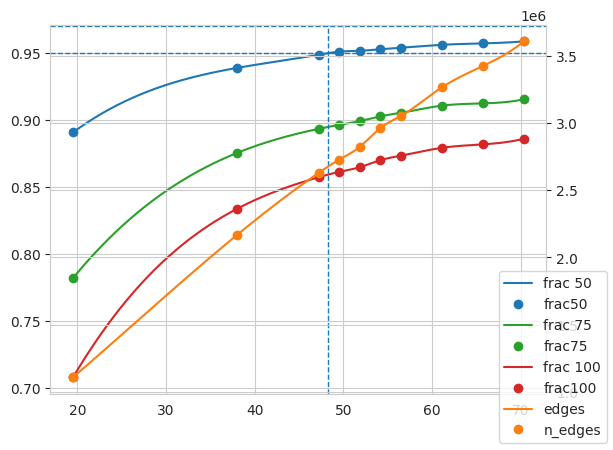

In [12]:
_rsr.plot()

In [27]:
rs = RadiusScanner(
    model_output=mos,
    radius_range=(0.1, 1),
    max_edges=5_000_000,
    target_fracs=[0.90, 0.95],
    max_num_neighbors=64,
)
rsr = rs()

[18:23:32 RadiusHP] DEBUG: Radius 0.550000 -> 50-segment: 0.903849, edges: 2132887.000000
[18:23:35 RadiusHP] DEBUG: Radius 0.325000 -> 50-segment: 0.699399, edges: 862704.000000
[18:23:35 RadiusHP] DEBUG: Updated min radius to 0.325000 (underarchieving)
[18:23:38 RadiusHP] DEBUG: Radius 0.775000 -> 50-segment: 0.956655, edges: 3321855.000000
[18:23:38 RadiusHP] DEBUG: Updated max radius to 0.775000 (overachieving)
[18:23:41 RadiusHP] DEBUG: Radius 0.437500 -> 50-segment: 0.829434, edges: 1444402.000000
[18:23:41 RadiusHP] DEBUG: Updated min radius to 0.437500 (underarchieving)
[18:23:44 RadiusHP] DEBUG: Radius 0.662500 -> 50-segment: 0.943358, edges: 2818284.000000
[18:23:47 RadiusHP] DEBUG: Radius 0.606250 -> 50-segment: 0.925585, edges: 2485012.000000
[18:23:50 RadiusHP] DEBUG: Radius 0.493750 -> 50-segment: 0.873290, edges: 1781025.000000
[18:23:50 RadiusHP] DEBUG: Updated min radius to 0.493750 (underarchieving)
[18:23:53 RadiusHP] DEBUG: Radius 0.718750 -> 50-segment: 0.952308, e

<Axes: >

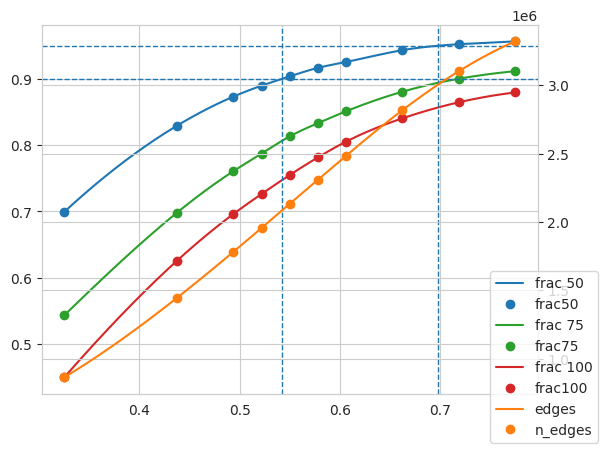

In [28]:
rsr.plot()

ValueError: 'bottom right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

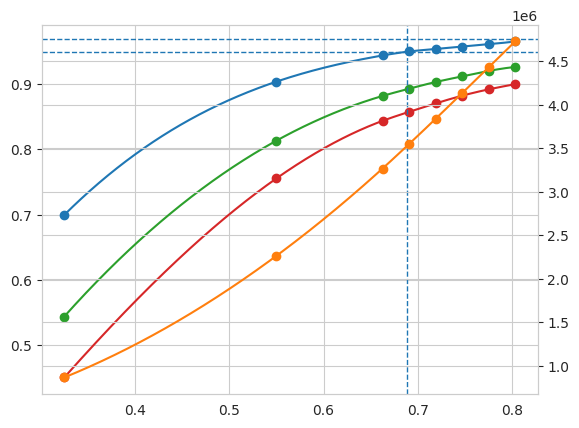

In [26]:
rsr.plot()

In [169]:
rsr.get_foms()

{'n_edges_frac_segment50_80': 1284219.4926314382,
 'n_edges_frac_segment50_80_r': 0.40723053430867795,
 'frac75_at_frac_segment50_80': 0.6600172349011211,
 'frac100_at_frac_segment50_80': 0.5820806287445455,
 'n_edges_frac_segment50_90': 2194204.7797816214,
 'n_edges_frac_segment50_90_r': 0.5413552825239967,
 'frac75_at_frac_segment50_90': 0.805757706466641,
 'frac100_at_frac_segment50_90': 0.7467926439706127,
 'n_edges_frac_segment50_95': 3566792.1154277846,
 'n_edges_frac_segment50_95_r': 0.68997604797421,
 'frac75_at_frac_segment50_95': 0.8935348906366549,
 'frac100_at_frac_segment50_95': 0.8579570863087999,
 'max_frac_segment50': 0.961513872906278,
 'n_edges_max_frac_segment50': 4548636.0,
 'max_frac_segment50_r': 0.775,
 'frac75_at_max_frac_segment50': 0.9204705280654648,
 'frac100_at_max_frac_segment50': 0.892341132847462}

(array([113., 123., 206., 152., 163., 111., 139., 122., 230., 126., 138.,
        129., 109., 123., 102., 122., 144., 138., 130., 109.,  77.,  89.,
        105., 112., 117.,  71.,  90., 116., 146., 104., 138., 109.,  84.,
         94.,  73., 110., 119., 101.,  99.,  95., 101., 114.,  79.,  74.,
         90.,  60.,  77.,  66.,  68.,  60.,  73.,  68.,  73.,  68.,  94.,
         72.,  61.,  51.,  78.,  84.,  71.,  86.,  86., 107.,  74., 110.,
         92.,  93.,  94.,  62.,  59.,  75.,  82.,  68.,  75.,  85., 100.,
         79.,  88.,  89.,  67., 109., 123., 181., 119., 102., 162., 133.,
        214., 172., 168., 111., 193., 104.,  77.,  22.,  11.,   2.,   0.,
          3.]),
 array([-4.02886391, -3.9446547 , -3.86044526, -3.77623606, -3.69202685,
        -3.60781741, -3.52360821, -3.43939877, -3.35518956, -3.27098036,
        -3.18677092, -3.10256171, -3.01835251, -2.93414307, -2.84993386,
        -2.76572466, -2.68151522, -2.59730601, -2.51309681, -2.42888737,
        -2.34467816, -2.26

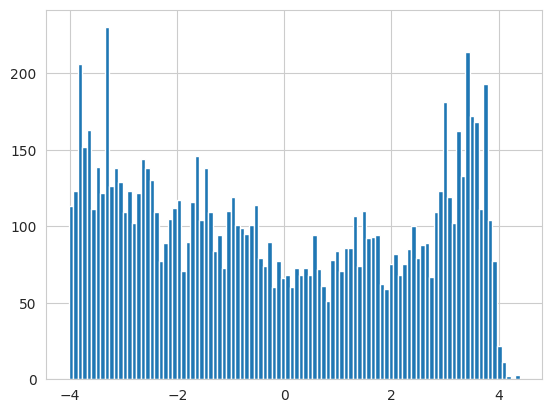

In [175]:
plt.hist(, bins=100)

In [176]:
selected_etas = data.x[(data.pt > 0.9) & (data.particle_id > 0), 3].cpu().numpy()
out_of_bound = np.abs(selected_etas) > 4

In [178]:
sum(out_of_bound) / len(selected_etas)

0.004184517286041646

In [187]:
import torch
p_oo_eta = (pd.DataFrame({"eta": torch.abs(data.x[:, 3]).cpu().numpy(), "pid": data.particle_id.cpu().numpy()}).groupby("pid").max() > 4).to_numpy()

In [189]:
sum(p_oo_eta) / len(torch.unique(data.particle_id))

array([0.00857143])

In [190]:
p_oo_eta = (pd.DataFrame({"eta": torch.abs(data.x[:, 3]).cpu().numpy(), "pid": data.particle_id.cpu().numpy()}).groupby("pid").mean() > 4).to_numpy()

In [191]:
sum(p_oo_eta) / len(torch.unique(data.particle_id))

array([0.00651429])